In [1]:
pip install numpy scikit-learn opencv-python matplotlib

In [47]:
import os
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.transform import resize
from skimage.io import imread
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [48]:
# Define ZIP file path
zip_path = "/content/training_set.zip"
extract_path = "/content/dataset"

In [50]:

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted successfully!")

In [51]:

print("Extracted folders:", os.listdir(extract_path))


Extracted folders: ['training_set']


In [52]:
dataset_path = "/content/dataset/training_set"

print("Checking dataset structure...")
print("Categories:", os.listdir(dataset_path))  # Should print ['cats', 'dogs']

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        print(f"\nCategory: {category}")
        print("Sample images:", os.listdir(category_path)[:5])  # Print first 5 images

Checking dataset structure...
Categories: ['dogs', 'cats']

Category: dogs
Sample images: ['dog.999.jpg', 'dog.95.jpg', 'dog.950.jpg', 'dog.951.jpg', 'dog.997.jpg']

Category: cats
Sample images: ['cat.1005.jpg', 'cat.1004.jpg', 'cat.100.jpg', 'cat.1011.jpg', 'cat.1007.jpg']


In [53]:
images = []
labels = []

# Load images from 'cats' and 'dogs' folders
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)

    if not os.path.isdir(category_path):
        continue  # Skip if not a directory

    print(f"📂 Processing category: {category}")

    for file_name in os.listdir(category_path):
        image_path = os.path.join(category_path, file_name)

        if not os.path.isfile(image_path):
            continue  # Skip if not a valid file

        # Read image
        image = cv2.imread(image_path)
        if image is None:
            print(f"🚨 Skipping unreadable image: {image_path}")
            continue

        # Convert to grayscale and resize
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (64, 64))

        # Extract HOG features
        features, _ = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

        images.append(features)
        labels.append(category)

📂 Processing category: dogs
🚨 Skipping unreadable image: /content/dataset/training_set/dogs/_DS_Store
📂 Processing category: cats
🚨 Skipping unreadable image: /content/dataset/training_set/cats/_DS_Store


In [54]:
# Convert lists to NumPy arrays
X = np.array(images)
y = np.array(labels)

In [55]:
# Ensure images were loaded
if len(X) == 0:
    raise ValueError("🚨 No images were loaded. Check dataset path and image format!")

print(f"✅ Successfully loaded {len(X)} images!")


✅ Successfully loaded 44 images!


**Balance Dataset to Prevent Bias**

In [57]:
print(" Checking class distribution before balancing:", Counter(y))

rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X, y)

print(" Class distribution after balancing:", Counter(y_balanced))


 Checking class distribution before balancing: Counter({'dogs': 26, 'cats': 18})
 Class distribution after balancing: Counter({'cats': 18, 'dogs': 18})


In [58]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)


In [59]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.2, random_state=42)


**Train SVM Model **

In [60]:
print("🚀 Training SVM Model...")

svm_model = SVC(C=1, kernel='rbf', gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train, y_train)


🚀 Training SVM Model...


SVC(C=1, probability=True, random_state=42)

**Predict and evaluate**

In [62]:
y_pred = svm_model.predict(X_test)

print(f"🎯 Model Accuracy: {accuracy_score(y_test, y_pred)}")
print("\n🔬 Classification Report:\n", classification_report(y_test, y_pred, target_names=['cats', 'dogs']))

🎯 Model Accuracy: 0.5

🔬 Classification Report:
               precision    recall  f1-score   support

        cats       0.43      1.00      0.60         3
        dogs       1.00      0.20      0.33         5

    accuracy                           0.50         8
   macro avg       0.71      0.60      0.47         8
weighted avg       0.79      0.50      0.43         8



**Test with a New Image**

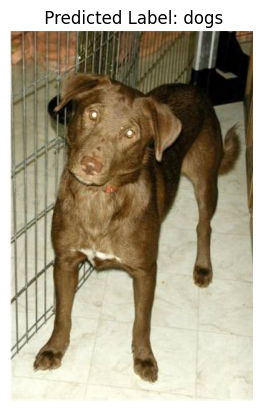

✅ Predicted Label: dogs


In [64]:
def preprocess_image(image_path):
    """Preprocess an image for prediction"""
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized_image = cv2.resize(gray_image, (64, 64))  # Resize

    features, _ = hog(resized_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features.flatten()

# Path to test image
test_image_path = "/content/dataset/training_set/dogs/dog.1.jpg"  # Update this path as needed

# Preprocess and normalize test image
preprocessed_image = preprocess_image(test_image_path)
reshaped_image = scaler.transform(preprocessed_image.reshape(1, -1))

# Predict label
prediction = svm_model.predict(reshaped_image)

# Display test image with prediction
img = imread(test_image_path)
plt.imshow(img)
plt.axis("off")
plt.title(f" Predicted Label: {prediction[0]}")
plt.show()

print(f"✅ Predicted Label: {prediction[0]}")

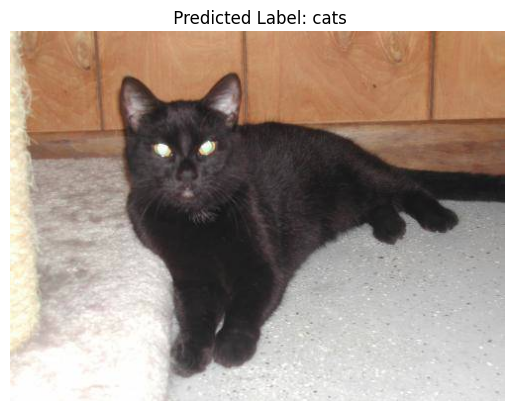

✅ Predicted Label: cats


In [66]:
def preprocess_image(image_path):
    """Preprocess an image for prediction"""
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized_image = cv2.resize(gray_image, (64, 64))  # Resize

    features, _ = hog(resized_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features.flatten()

# Path to test image
test_image_path = "/content/dataset/training_set/cats/cat.1007.jpg"  # Update this path as needed

# Preprocess and normalize test image
preprocessed_image = preprocess_image(test_image_path)
reshaped_image = scaler.transform(preprocessed_image.reshape(1, -1))

# Predict label
prediction = svm_model.predict(reshaped_image)

# Display test image with prediction
img = imread(test_image_path)
plt.imshow(img)
plt.axis("off")
plt.title(f" Predicted Label: {prediction[0]}")
plt.show()

print(f"✅ Predicted Label: {prediction[0]}")

**🧑‍💻By:Rishin Aiyappa A G**